In [1]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from keras.models import load_model
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Activation, GRU, Dense, Input, Add, Concatenate, Reshape, Lambda
from keras.optimizers import SGD
from keras import backend as K
import numpy as np
import keras

Using TensorFlow backend.


In [0]:
import pickle

with open('drive/My Drive/Machine_Learning-prj/vietnamese_address/images_64_1595.pkl', 'rb') as f:
    images = pickle.load(f)
    
with open('drive/My Drive/Machine_Learning-prj/vietnamese_address/scripts_64_1595.pkl', 'rb') as f:
    scripts = pickle.load(f)

In [0]:
import pickle

with open('drive/My Drive/Machine_Learning-prj/vietnamese_address/images_address.pkl', 'rb') as f:
    images_address = pickle.load(f)
    
with open('drive/My Drive/Machine_Learning-prj/vietnamese_address/scripts_address.pkl', 'rb') as f:
    scripts_address = pickle.load(f)

In [0]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [0]:
alphabet = u'\ !%"#&\'()*+,-./0123456789:;?AÁẢÀÃẠÂẤẨẦẪẬĂẮẲẰẴẶBCDĐEÉẺÈẼẸÊẾỂỀỄỆFGHIÍỈÌĨỊJKLMNOÓỎÒÕỌÔỐỔỒỖỘƠỚỞỜỠỢPQRSTUÚỦÙŨỤƯỨỬỪỮỰVWXYÝỶỲỸỴZaáảàãạâấẩầẫậăắẳằẵặbcdđeéẻèẽẹêếểềễệfghiíỉìĩịjklmnoóỏòõọôốổồỗộơớởờỡợpqrstuúủùũụưứửừữựvwxyýỷỳỹỵz'

def text_to_labels(text):
    ret = []
    for char in text:
        ret.append(alphabet.find(char))
    return ret


# Reverse translation of numerical classes back to characters
def labels_to_text(labels):
    ret = []
    for c in labels:
        if c == len(alphabet):  # CTC Blank
            ret.append("")
        else:
            ret.append(alphabet[c])
    return "".join(ret)

In [7]:
img_w = 1595
# Input Parameters
img_h = 64
# Network parameters
conv_filters = 16
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 256
rnn_size = 256
minibatch_size = 32
unique_tokens = 216

 
input_shape = (img_w, img_h, 1)

act = 'relu'
input_data = Input(name='the_input', shape=input_shape, dtype='float32')

inner = Conv2D(64, 3, padding='same', activation=act,name='conv1', kernel_initializer='he_normal')(input_data)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)
inner = Conv2D(128, 3, padding='same',activation=act, name='conv2', kernel_initializer='he_normal')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)

inner = Conv2D(256, 3, padding='same',activation=act, name='conv3', kernel_initializer='he_normal')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max3')(inner)

conv_to_rnn_dims = (256, 199*8)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

# cuts down input size going into RNN:
inner = Dense(time_dense_size, activation=act, kernel_initializer='he_normal', name='dense1')(inner)

# Two layers of bidirectional GRUs
# GRU seems to work as well, if not better than LSTM:
gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
gru1_merged = Add()([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', go_backwards=True, name='gru2_b')(gru1_merged)

# transforms RNN output to character activations:
inner = Dense(unique_tokens,name='dense2')(Concatenate()([gru_2, gru_2b]))
y_pred = Activation('softmax', name='softmax')(inner)

# #Get text predict
# out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1],
#                          greedy=True)[0][0])

Model(inputs=input_data, outputs=y_pred).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 1595, 64, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 1595, 64, 64) 640         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 797, 32, 64)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 797, 32, 128) 73856       max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

In [0]:
labels = Input(name='the_labels', shape=[256, ], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
# Keras doesn't currently support loss funcs with extra parameters
# so CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# clipnorm seems to speeds up convergence
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
# rms = RMSprop(lr=0.001, clipnorm=5, clipvalue=0.5)

In [0]:
model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

In [0]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 1595, 64, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 1595, 64, 64) 640         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 797, 32, 64)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 797, 32, 128) 73856       max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

In [0]:
model.load_weights('drive/My Drive/Machine_Learning-prj/vietnamese_address/weight/20xaugument-weights-training-improvement-70-63.54.hdf5')

In [0]:
test_func = K.function([input_data], [y_pred])

In [0]:
model_p = Model(inputs=input_data, outputs=y_pred)

In [0]:
def decode_predict_ctc(out, top_paths = 1):
    results = []
    beam_width = 5
    print(out.shape)
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        lables = K.get_value(K.ctc_decode(out, input_length=np.ones(1, dtype=np.float32) * 254,
                           greedy=False, beam_width=beam_width, top_paths=top_paths)[0][i])[0]
        text = labels_to_text(lables)
        results.append(text)
    return results

In [0]:
from matplotlib import pyplot as plt
import cv2

In [0]:
def predict(x, images, scripts):
    plt.imshow(images[x])
    plt.show()

    image = images[x]
    image = image/255.
    image = cv2.copyMakeBorder(image, 0, 0, 0, 1595 - image.shape[1] ,cv2.BORDER_CONSTANT,value=0)
    image = np.reshape(image, (1, 64, 1595, 1))
    image = image.transpose((0, 2, 1, 3))

    net_out_value = model_p.predict(image)
    pred_texts = decode_predict_ctc(net_out_value)
    print("PREDICT:" + pred_texts[0])
    print("LABELS: " + scripts[x]) 

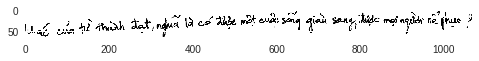

(1, 256, 216)
PREDICT:(khác của từ thành đạt, nghĩa là có được một cuộc ống giàu sang được mọi người rể phục?
LABELS: khác của từ thành đạt, nghĩa là có được một cuộc sống giàu sang, được mọi người nể phục?


In [28]:
#Dataset anh Toan/ Trained image
predict(50, images, scripts)

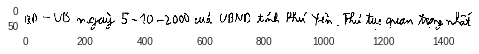

(1, 256, 216)
PREDICT:(C1 - 28 ngày 5 - 10 - 20 của UBN) tỉnh Phú Yên. thủ tục quan trộng nhất
LABELS: QĐ - UB ngày 5 - 10 - 2000 của UBND tỉnh Phú Yên. Thủ tục quan trọng nhất


In [29]:
#Dataset anh Toan/ Valid  image
predict(7120, images, scripts)

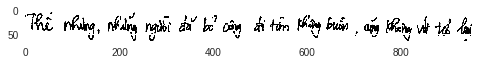

(1, 256, 216)
PREDICT:Thế nhưng, những người đã bỏ công đi tiềm phông buển, cậyg không vớứt trở lại
LABELS: Thế nhưng, những người đã bỏ công đi tìm không buồn, cũng không vứt trở lại


In [31]:
# Dataset anh Toan/ Not-trained  image
# predict(7202, images, scripts)

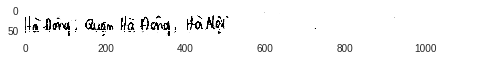

(1, 256, 216)
PREDICT: (Hà Đông, Cuận Hà Đhồng, Hà Nếi 
LABELS: Hà Đông, Quận Hà Đông, Hà Nội


In [21]:
# Dataset address/ Trained image
# predict(220, images_address, scripts_address)

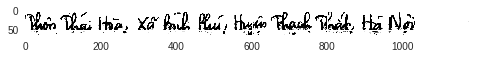

(1, 256, 216)
PREDICT:T Tân Thại Hàm đã bịnh Pá, Huyện Định Thát Hộ Một 
LABELS: Thôn Thái Hòa, Xã Bình Phú, Huyện Thạch Thất, Hà Nội


In [22]:
# Dataset address/ Valid image
# predict(1750, images_address, scripts_address)

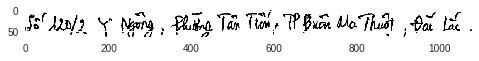

(1, 256, 216)
PREDICT:Số 103 P Ngàng, Phương Tân Tến, TP puồn ló Phuợt, Đai lắc.
LABELS: Số 120/2 Y Ngông, Phường Tân Tiến, TP.Buôn Ma Thuột, Đắc Lắc


In [23]:
# Dataset address/ Non-trained image
# predict(1815, images_address, scripts_address)